In [1]:
import numpy as np 
import pandas as pd 
import nltk
 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vizyon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Türkçe Twitter verileriyle duygu analiz nasıl yapılır? Bu çalışmada tamamen bizim tarafımızdan elde edilen 4202 adet ileti etiketlenerek analiz edilecektir. Duygu ifadeleri metnin anlamından oluşturulmuştur. Buna göre, nötr ifadeler 0 ile, negatifler 1 ile ve pozitifler 2 ile etiketlenmiştir. Veri dosyamızı çağıralım ve inceleyelim.

In [2]:
data=pd.read_excel('duygu.xlsx')  
data.head()

,Tweets,Duygu
0,sayın cumhurbaşkanım turizm için ertelendiğin...,1
1,bir kere ya bir kere gencinizi dinleyin biz y...,1
2,o kadar çok mağduruz ki neye üzüleceğime şaşır...,1
3,bu sınav tarihini değiştirirken pedaloglara v...,1
4,turizm yılı gençlik geleceğinizi kurtarır,2


Verimizdeki kategorilerin kaç adet olduğunu şu şekilde bulabiliriz.

In [22]:
data['Duygu'].value_counts()

1    1572
2    1472
0    1158
Name: Duygu, dtype: int64

Buna göre verimizin 1158 adedi  nötr, 1572 negatif ve  1472 pozitif olarak etiketlenmiştir.

Uygulamaya geçmeden önce verinin analize hazır hale getirilmesi büyük önem arz eder. Bu sürece veri ön işleme (Data Preprocessing) denir. Bunun için şu adımlar kullanılır.
Uygulamada çok olsa da kendimizin oluşturduğu durak kelimeleri(ama, ve, ile, hiç vb...) dosyasını açıp 'stop' adlı dosyaya atalım.

In [3]:
with open("StopWordTurkce.txt", "r") as dosya:
    stop = dosya.read() 

şimdi verimizdeki gereksiz kelimeleri atmak için bir fonksiyon yazalım 

In [4]:
def text_preprocess(text):
    
    text = [word for word in text.split() if word not in stop]
    return " ".join(text)

bu fonksiyonu verimizdeki metin (Tweet) sütununa uygulayıp yeni bir sütun oluşturup farklara bakalım.

In [5]:
data['stop'] = data['Tweets'].apply(text_preprocess)

In [6]:
data.head(10)

,Tweets,Duygu,stop
0,sayın cumhurbaşkanım turizm için ertelendiğin...,1,sayın cumhurbaşkanım turizm ertelendiğini bili...
1,bir kere ya bir kere gencinizi dinleyin biz y...,1,gencinizi dinleyin yanlış demiyoruz doğrusunu ...
2,o kadar çok mağduruz ki neye üzüleceğime şaşır...,1,mağduruz üzüleceğime şaşırdım yerden destek al...
3,bu sınav tarihini değiştirirken pedaloglara v...,1,sınav tarihini değiştirirken pedaloglara psiko...
4,turizm yılı gençlik geleceğinizi kurtarır,2,turizm yılı gençlik geleceğinizi kurtarır
5,sizden kıyak isteyen yok turizm yüzünden yedi...,1,kıyak isteyen turizm yediğiniz hakkımızı geri ...
6,bunu söylemek bile üzüyor ama turizm bu kadar...,1,söylemek üzüyor turizm değerliyse sınavı ağust...
7,mayıs ı gençlere armağan eden ulu önder musta...,1,mayıs gençlere armağan ulu önder mustafa kemal...
8,turizm mi önemli ülkenin geleceği olan bizler...,1,turizm önemli ülkenin geleceği bizler
9,erteleyin son iftarlarimizi rahat yapalım sağ...,1,erteleyin iftarlarimizi rahat yapalım sağlık b...


yukarıda da görüldüğü gibi bir anlam ifade etmeyen kelime gruplarından kurtulduk. Böylece vektör uzayının hacmi büyük bir yükten kurtuldu.

yinede tam bir yapılandırma için bir adım kaldı. o da kelimeleri çekim ve yapım ekleri nedeniyle oluşan varyosyonlardan kurtararak (sevmek=sevilmek,sevgi,sevinç vb...  ) köke ayrıma ya da diğer adıyla Steeming işlemine tabii tutmamız gerekecek. Maalesef İngilizce için başarılı çalışmaların olduğu kütüphaneler mevcutken Türkçe için en değerli çalışma TurkishStemmer ya da Zemberek kütüphaneleridir. Onlar da çok başarılı olmasa da mevcut şartlarda yeterli sayılabilir. 



In [7]:
from TurkishStemmer import TurkishStemmer

kokbul = TurkishStemmer()

yine burada tüm kelimeleri köküne indirgemeyi sağlayacak bir fonksiyon yazıp, bunuda 'stop' sütununa uyguladığımızda boyut indirgeme sağlanacaktır

In [8]:
def stemming(text):
    words=word_tokenize(text)
    stems=[]

    for w in words:
        stems.append(kokbul.stem(w))
        
    return ' '.join(stems)



In [9]:
data['stemm'] = data['stop'].apply(stemming)

In [10]:
data.head()

,Tweets,Duygu,stop,stemm
0,sayın cumhurbaşkanım turizm için ertelendiğin...,1,sayın cumhurbaşkanım turizm ertelendiğini bili...,say cumhurbaşkan turizm ertelendik biliyor uyg...
1,bir kere ya bir kere gencinizi dinleyin biz y...,1,gencinizi dinleyin yanlış demiyoruz doğrusunu ...,genç dinley yanlış demiyor doğru söylüyor
2,o kadar çok mağduruz ki neye üzüleceğime şaşır...,1,mağduruz üzüleceğime şaşırdım yerden destek al...,mağdur üzülecek şaşır yer destek alamıyor yasa...
3,bu sınav tarihini değiştirirken pedaloglara v...,1,sınav tarihini değiştirirken pedaloglara psiko...,sınav tarih değiştirir pedalog psikolog danışı...
4,turizm yılı gençlik geleceğinizi kurtarır,2,turizm yılı gençlik geleceğinizi kurtarır,turizm yıl gençlik gelecek kurtarır


görüldüğü gibi yağmasa da gürledi. En azından bu alanda ne kadar önemli bir boşluğun olduğunu görmüş olduk

Artık ham veriyi belirli bir ön işlemeden geçirerek analize hazır hale getirdik, şimdi verimizi bağımlı ve bağımsız değişkenlere ayırarak süreci başlatalım

In [11]:
x = data['stemm']
y = data['Duygu']

bu adımda ise verimizi test ve eğitim seti olarak ikiye ayıracğız. 

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 42)

Burada kelimeleri algoritmanın anlayacağı dile çevirmek yani asyısallaştırmak için en çok kullanılan yöntemlerden biri olan TF-IDF (Term Frequency - Inverse Document Frequency ) terim ağırlıklandırma yöntemini kullanacağız. TF-TDF, verideki bir kelimenin frekansını, o kelimeyi içeren toplam doküman sayısı ve tüm dokümanların sayısına dayalı olarak hesaplayan  ağırlıklandırma yöntemidir. Böylece verideki önemsiz değerler elenerek önemli öznitelikler tespit edilir ve sınıflandırma işlemi sırasında performans artışı sağlanır.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

Artık gerek test gerekse da eğitim setindeki bağımsız değişken olan 'x'in içindeki metinleri sayısallaştırabiliriz 

In [14]:
vectorizer = TfidfVectorizer()

vectorizer.fit(x_train)
training_features = vectorizer.transform(x_train)    
test_features = vectorizer.transform(x_test)


boyutu çok büyük olan Vektör uzay modelimiz analize hazır sınıflacısını beklemektedir. şimdi Destek Vektör Makineleri (Support Vector Machine) algoritmasının çağıralım

In [15]:
from sklearn.svm import SVC
# Destek Vektör Makineleri (Support Vector Machine) algoritmasının birçok hiper parametresi vardır.
# bunu araştırmacı manuel olarak belirlediği gibi parametreleri liste halinde sunarak ''GridSearchCV" arama ızgarasında
#eğitim verisi doğruluk skoruna göre tespit edebilir.
parametreler = {'C': [1, 10, 100, 1000], 'kernel': ['linear','rbf'],
              'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
# hiper parametrelerin  doğruluk skorlarını oluştur
acc_scorer = make_scorer(accuracy_score)
# her parametrenin doğrulluk skorunu tek tek hesaplayan "GridSearchCV" ızgarasını oluştur. 
#bunun için egitim verisine 10 kez çapraz geçerlilik sınaması yap
grid_obj = GridSearchCV(SVC(), parametreler, cv=10, scoring=acc_scorer)
grid_obj = grid_obj.fit(training_features, y_train)
# bulunan en iyi parametre kümesini modele ata ve modeli oluştur.
model = grid_obj.best_estimator_



In [16]:
accuracy = grid_obj.best_score_    # En iyi modelin doğruluğu hesaplanır.
accuracy

0.6447485867301398

en iyi parametreleri bulunan modelin doğruluk oranı bulundu. artık eğitim verisini bu modele göre işleyebilriz 

In [17]:
model.fit(training_features, y_train) # aşağıda, oluşturduğumuz modelin hiper parametreleri gösterilmektedir

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.8, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Şimdi de test verisindeki x değişkenini kullanarak model üzerinden y değişkenini tahmin edelim.
ardından modelin bulduğu tahmini veri(y-pred )ile gerçek test (y-test) verisi arasındaki benzerlik oranını bulacağız

In [18]:
y_pred = model.predict(test_features)

In [19]:
print("Accuracy_score on the dataset:{:.2f}".format(accuracy_score(y_test, y_pred)))

Accuracy_score on the dataset:0.64


görüldüğü gibi modelimizin test verilerini tahmin güçü çok istinilen seviye de olmasada idare eder. bu oranı büyütmek için birçok düzenleme yapılabalinir. örneğin veri sayısını arttırmak bunların en önemlisidir.

şimdi modelimizin atadığı kategoriyle test verisinin (gerçek) kategorileri arsasındaki  doğru ve yanlış eşleştirmeleri ortaya koyacak olan karşılaştırma matrisini inceleyelim.

Text(89.18, 0.5, 'predicted label')

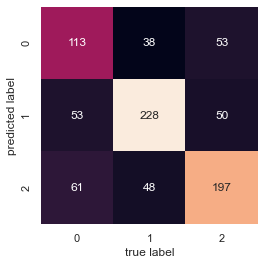

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False
            )
plt.xlabel('true label')
plt.ylabel('predicted label')

Confusion matrixin köşegenleri üzerindeki sayılar doğrueşlemeyi, diğer sayılar yanlış eşlemeyi gösterir. İdeal bir modelde matrisin diagonel olması istenir. yani köşegen dışındaki sayıların sıfır olması mükemmel modelleme olduğuna işarettir. Buna göre nötr ifadelerin 113'ü, negatiflerin 228'i ve pozitiflerin 197'si doğru atanmıştır. modelin tahmin gücü % 64 olarak bulundu.  